In [54]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from matplotlib.patches import Rectangle
import seaborn as sns

%matplotlib inline
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/figs2"


In [55]:
results_dir = "/Users/crankshaw/clipper/experiments_logs/batching_strat_comparison"

results = {}
for name in os.listdir(results_dir):
    if "results" in name:
        strat = name.split("_")[1]
        with open(os.path.join(results_dir, name)) as f:
            if strat == "aimd":
                strat = "Adaptive"
            elif strat == "learned":
                strat = "Quantile Regression"
            elif strat == "static":
                strat = "No Batching"
            results[strat] = json.load(f)
        


[(u'noop', 48386.30200740236), (u'rf_d16', 22859.18297547248), (u'spark_svm', 29350.773531023395), (u'linear_svm', 48934.23695218708), (u'kernel_svm', 197.90056449564975), (u'logistic_reg', 47219.946491643306)]
[(u'noop', 46084.913335547266), (u'rf_d16', 19903.653371829972), (u'spark_svm', 27742.787468947885), (u'linear_svm', 47879.31465579214), (u'kernel_svm', 188.53730193114018), (u'logistic_reg', 43954.2864824583)]
[(u'noop', 8963.639747028232), (u'rf_d16', 317.0807560431576), (u'spark_svm', 7206.5846527887825), (u'linear_svm', 353.09095278150755), (u'kernel_svm', 203.46167592796857), (u'logistic_reg', 353.11127456296265)]


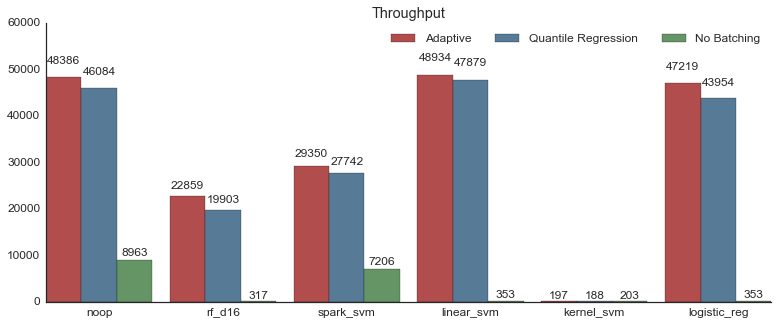

In [87]:
sns.set_palette("Paired")
# sns.set_style("whitegrid", {"axes.grid": "False"})
sns.set_style("white")
sns.set_context("paper", font_scale=1.5,)

def plot_thruputs(results):
    fig, ax = plt.subplots(figsize=(13,5))
    sns.despine()
    width = 1
    space = 0.5
    num_bars = len(results)
    offset = 0
    colors = sns.color_palette("Set1", n_colors=8, desat=.5)
    rects = []
    for strat in ["Adaptive", "Quantile Regression", "No Batching"]:
        thrus = [(m["name"].split(":")[0], m["rate"]) for m in results[strat]["meters"] if "model_thruput" in m["name"]]
        model_names, rates = zip(*thrus)
        print thrus
        rects.append(ax.bar(np.arange(len(rates))*width*(num_bars+ space) + width*offset, rates, color=colors[offset], width=width, label=strat))
        if offset == 0:
            plt.xticks(np.arange(len(rates))*width*(num_bars + space) + width*(num_bars/2.0), model_names)
        offset += 1
    ax.set_ylim(0, 60000)

    ax.set_title("Throughput")
    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height), size=12,
                    ha='center', va='bottom')
    
    [autolabel(r) for r in rects]
    ax.legend(loc=0,ncol=3)

    
#     plt.show()
    plt.savefig("%s/batching_strategy_comp_thru.pdf" % (fig_dir), bbox_inches='tight')
        
plot_thruputs(results)



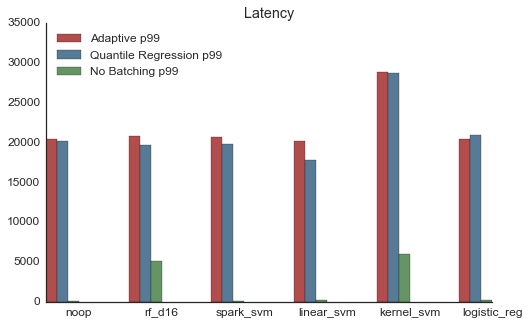

In [71]:
def plot_latencies(results):
    fig, ax = plt.subplots(figsize=(8,5))
    sns.despine()
    width = 1
    space = 1.5
    num_bars = len(results)*2
    offset = 0
    colors = sns.color_palette("Set1", n_colors=8, desat=.5)

    for strat in ["Adaptive", "Quantile Regression", "No Batching"]:
#         thrus = [(m["name"].split(":")[0], m["rate"]) for m in results[strat]["meters"] if "model_thruput" in m["name"]]
#         model_names, rates = zip(*thrus)
        
        p99 = [(m["name"].split(":")[0], m["p99"]) for m in results[strat]["histograms"] if "model_latency" in m["name"]]
        model_names, lats = zip(*p99)
        ax.bar(np.arange(len(lats))*width*(num_bars+ space) + width*offset, lats, color=colors[offset], width=width, label="%s p99" % strat)
        if offset == 0:
            plt.xticks(np.arange(len(lats))*width*(num_bars + space) + width*(num_bars/2.0), model_names)
#         offset += 1
#         mean_lats = [(m["name"].split(":")[0], m["mean"]) for m in results[strat]["histograms"] if "model_latency" in m["name"]]
#         model_names, means = zip(*mean_lats)
#         ax.bar(np.arange(len(means))*width*(num_bars+ space) + width*offset, means, color=colors[offset], width=width, label="%s mean" % strat)
        if offset == 0:
            plt.xticks(np.arange(len(lats))*width*(num_bars + space) + width*(num_bars/2.0), model_names)
        offset += 1
        
        
    ax.set_ylim(0, 35000)
    ax.legend(loc=0,ncol=1)

    ax.set_title("Latency")
#     plt.show()
    plt.savefig("%s/batching_strategy_comp_lat.pdf" % (fig_dir), bbox_inches='tight')
        
plot_latencies(results)


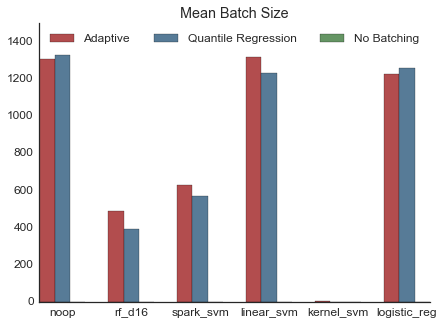

In [68]:
def plot_batch_sizes(results):
    fig, ax = plt.subplots(figsize=(7,5))
    sns.despine()
    width = 1
    space = 1.5
    num_bars = len(results)
    offset = 0
    colors = sns.color_palette("Set1", n_colors=8, desat=.5)

    for strat in ["Adaptive", "Quantile Regression", "No Batching"]:
#         thrus = [(m["name"].split(":")[0], m["rate"]) for m in results[strat]["meters"] if "model_thruput" in m["name"]]
#         model_names, rates = zip(*thrus)
        
        mean_b = [(m["name"].split(":")[0], m["mean"]) for m in results[strat]["histograms"] if "model_batch" in m["name"]]
        model_names, bs = zip(*mean_b)
        
        
        ax.bar(np.arange(len(bs))*width*(num_bars+ space) + width*offset, bs, color=colors[offset], width=width, label=strat)
        if offset == 0:
            plt.xticks(np.arange(len(bs))*width*(num_bars + space) + width*(num_bars/2.0), model_names)
        offset += 1
    ax.set_ylim(0, 1500)
#     ax.set_yscale("log")
    ax.legend(loc=0,ncol=3)

    ax.set_title("Mean Batch Size")
#     plt.show()
    plt.savefig("%s/batching_strategy_comp_batch_size.pdf" % (fig_dir), bbox_inches='tight')
        
plot_batch_sizes(results)
